**7. Train Two Models**

In [ ]:
!pip uninstall Cython -y

In [ ]:
# Uninstalling Cython and cloning TensorFlow models
!git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [ ]:
# Modifying the setup.py file
import re
with open('/content/models/research/object_detection/packages/tf2/setup.py') as f:
    s = f.read()
with open('/content/models/research/setup.py', 'w') as f:
    s = re.sub('tf-models-official>=2.5.1',
               'tf-models-official==2.8.0', s)
    f.write(s)

In [ ]:
!pip install pyyaml==5.3
!pip install /content/models/research/
!pip install tensorflow==2.8.0

In [ ]:
# Testing the installation
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py


In [ ]:
# Downloading the dataset from my Repo(dataset downloaded from Roboflow)
import urllib.request

dataset_url = 'https://github.com/Mithoonns2001/dataset/raw/main/animal_images.zip'

urllib.request.urlretrieve(dataset_url, '/content/animal_images.zip')


('/content/animal_images.zip', <http.client.HTTPMessage at 0x7ae5c9860cd0>)

In [ ]:
# Extracting the dataset
!unzip -q /content/animal_images.zip -d /content

In [ ]:
train_record_fname = '/content/animal_images/train/animals.tfrecord'
val_record_fname = '/content/animal_images/valid/animals.tfrecord'
label_map_pbtxt_fname = '/content/animal_images/animals_label_map.pbtxt'

Select Any one Model to train

In [ ]:
# Configuring and selecting a model for training

# chosen_model = 'ssd-mobilenet-v2-fpnlite-320'
chosen_model = 'efficientdet-d0'

# model_folder_name='ssd_mobilenet'
model_folder_name='EfficientDet'

MODELS_CONFIG = {
    'ssd-mobilenet-v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
    },
    'ssd-mobilenet-v2-fpnlite-320': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz',
    }
}

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']

In [ ]:
%mkdir /content/models/mymodel_{model_folder_name}/
%cd /content/models/mymodel_{model_folder_name}/


/content/models/mymodel_ssd_mobilenet


In [ ]:
# Pre-trained model weights
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint
!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

# training configuration file for the model
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

In [ ]:
# Parameters
num_steps = 10000
batch_size = 16

In [ ]:
pipeline_fname = f'/content/models/mymodel_{model_folder_name}/' + base_pipeline_file
fine_tune_checkpoint = f'/content/models/mymodel_{model_folder_name}/' + model_name + '/checkpoint/ckpt-0'

# Number of classes
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)
print('Total classes:', num_classes)


Total classes: 10


In [ ]:
import re

%cd /content/models/mymodel_{model_folder_name}

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:

    # Set fine_tune_checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)

    # Set tfrecord files for train and test datasets
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    # Set label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set batch_size
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)

    # Set number of classes num_classes
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)

    # Change fine-tune checkpoint type from classification to detection
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)

    if chosen_model == 'ssd-mobilenet-v2':
      s = re.sub('learning_rate_base: .8',
                 'learning_rate_base: .08', s)

      s = re.sub('warmup_learning_rate: 0.13333',
                 'warmup_learning_rate: .026666', s)

    if chosen_model == 'efficientdet-d0':
      s = re.sub('keep_aspect_ratio_resizer', 'fixed_shape_resizer', s)
      s = re.sub('pad_to_max_dimension: true', '', s)
      s = re.sub('min_dimension', 'height', s)
      s = re.sub('max_dimension', 'width', s)

    f.write(s)


In [ ]:
# (Optional) Display the custom configuration file's contents
!cat /content/models/mymodel_{model_folder_name}/pipeline_file.config

In [ ]:
pipeline_file = f'/content/models/mymodel_{model_folder_name}/pipeline_file.config'
model_dir = f'/content/training_{model_folder_name}/'

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir f'/content/training_{model_folder_name}/train'

In [ ]:
# Training/Fine-tuning the model
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1

In [ ]:
#Export the Trained Model to TensorFlow Lite
!mkdir /content/{model_folder_name}
output_directory = f'/content/{model_folder_name}'

last_model_path = f'/content/training_{model_folder_name}'

!python /content/models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}


In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model(f'/content/{model_folder_name}/saved_model')
tflite_model = converter.convert()

with open(f'/content/{model_folder_name}/detect.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
model_folder_name_1 = 'ssd_mobilenet'
model_folder_name_2 = 'EfficientDet'

import os
import cv2
import numpy as np
import sys
import glob
import random
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

    images = glob.glob(imgpath + '/*.jpg') + glob.glob(imgpath + '/*.JPG') + glob.glob(imgpath + '/*.png') + glob.glob(imgpath + '/*.bmp')

    with open(lblpath, 'r') as f:
        labels = [line.strip() for line in f.readlines()]

    interpreter_1 = Interpreter(model_path=modelpath)
    interpreter_1.allocate_tensors()

    input_details_1 = interpreter_1.get_input_details()
    output_details_1 = interpreter_1.get_output_details()
    height_model_1, width_model_1 = input_details_1[0]['shape'][1], input_details_1[0]['shape'][2]

    float_input_1 = (input_details_1[0]['dtype'] == np.float32)

    # images_to_test = imgpath # for single path
    images_to_test = random.sample(images, num_test_images)

    for image_path in images_to_test:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        imH, imW, _ = image.shape

        # Model
        input_frame_1 = cv2.resize(image_rgb, (width_model_1, height_model_1))
        input_data_1 = np.expand_dims(input_frame_1, axis=0)

        if float_input_1:
            input_data_1 = (np.float32(input_data_1) - 127.5) / 127.5

        interpreter_1.set_tensor(input_details_1[0]['index'], input_data_1)
        interpreter_1.invoke()

        # Result for Model
        boxes_1 = interpreter_1.get_tensor(output_details_1[1]['index'])[0]
        classes_1 = interpreter_1.get_tensor(output_details_1[3]['index'])[0]
        scores_1 = interpreter_1.get_tensor(output_details_1[0]['index'])[0]

        detections_1 = []

        for i in range(len(scores_1)):
            if (scores_1[i] > min_conf) and (scores_1[i] <= 1.0):
                ymin, xmin, ymax, xmax = boxes_1[i]
                detections_1.append([labels[int(classes_1[i])], scores_1[i], int(xmin * width_model_1), int(ymin * height_model_1), int(xmax * width_model_1), int(ymax * height_model_1)])

        if txt_only == False:
            plt.figure(figsize=(12, 6))

            # Display results for Model
            plt.subplot(1, 2, 1)
            plt.imshow(image_rgb)
            for detection in detections_1:
                xmin, ymin, xmax, ymax = detection[2:]
                xmin = int(xmin * imW / width_model_1)
                xmax = int(xmax * imW / width_model_1)
                ymin = int(ymin * imH / height_model_1)
                ymax = int(ymax * imH / height_model_1)
                plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='green', linewidth=2))
                plt.text(xmin, ymin, f"{detection[0]}: {detection[1]:.2f}", color='green', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

            plt.show()

        elif txt_only == True:
            image_fn = os.path.basename(image_path)
            base_fn, ext = os.path.splitext(image_fn)
            txt_result_fn_1 = base_fn + '_model1.txt'
            txt_result_fn_2 = base_fn + '_model2.txt'
            txt_savepath_1 = os.path.join(savepath, txt_result_fn_1)
            txt_savepath_2 = os.path.join(savepath, txt_result_fn_2)

            with open(txt_savepath_1, 'w') as f1:
                for detection in detections_1:
                    f1.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

    return


In [ ]:

PATH_TO_IMAGES = '/content/animal_images/test_image'
PATH_TO_MODEL = f'/content/{model_folder_name_1}/detect.tflite'
# PATH_TO_MODEL = f'/content/{model_folder_name_2}/detect.tflite'
PATH_TO_LABELS = '/content/animal_images/label_map.txt'
min_conf_threshold = 0.3
images_to_test = 10

tflite_detect_images(PATH_TO_MODEL,PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)


In [ ]:
!cp /content/animal_images/label_map.txt /content/{model_folder_name}
!cp /content/animal_images/animals_label_map.pbtxt /content/{model_folder_name}
!cp /content/models/mymodel_{model_folder_name}/pipeline_file.config /content/{model_folder_name}

%cd /content
!zip -r {model_folder_name}.zip {model_folder_name}

In [ ]:
# Downloading Model
from google.colab import files

files.download(f'/content/{model_folder_name}.zip')

Real-time inference

In [1]:
# Dataset
import urllib.request

dataset_url = 'https://github.com/Mithoonns2001/dataset/raw/main/animal_images.zip'

urllib.request.urlretrieve(dataset_url, '/content/animal_images.zip')

!unzip -q /content/animal_images.zip -d /content

In [2]:
# Model 1
import urllib.request

dataset_url = 'https://github.com/Mithoonns2001/dataset/raw/main/ssd_mobilenet.zip'

urllib.request.urlretrieve(dataset_url, '/content/ssd_mobilenet.zip')

!unzip -q /content/ssd_mobilenet.zip -d /content

In [3]:
# Model 2
import urllib.request

dataset_url = 'https://github.com/Mithoonns2001/dataset/raw/main/EfficientDet.zip'

urllib.request.urlretrieve(dataset_url, '/content/EfficientDet.zip')

!unzip -q /content/EfficientDet.zip -d /content

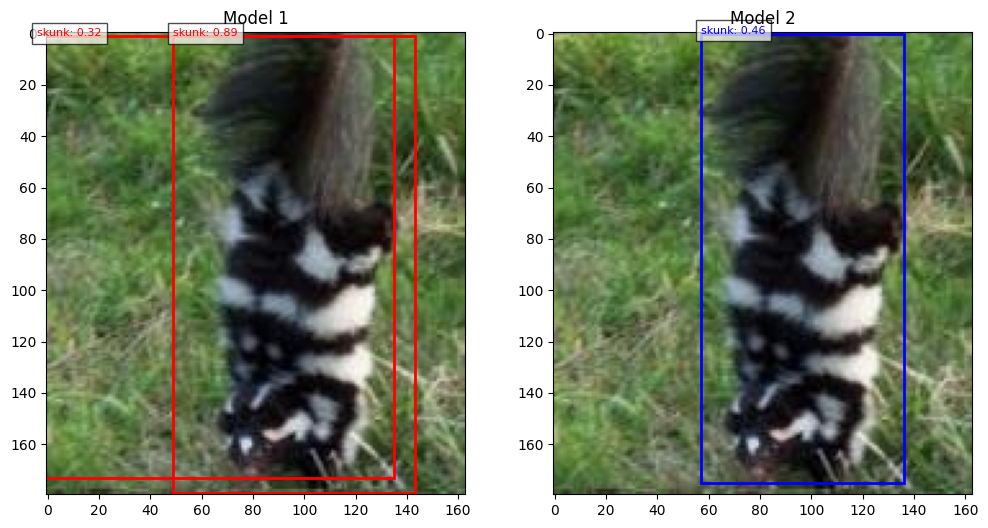

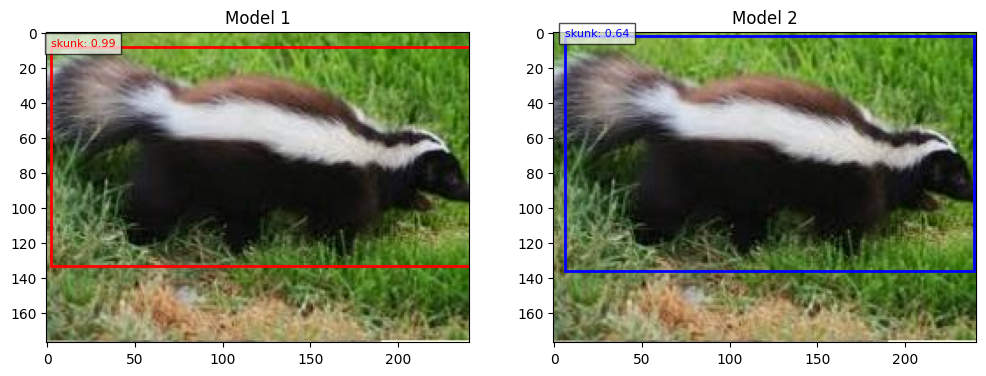

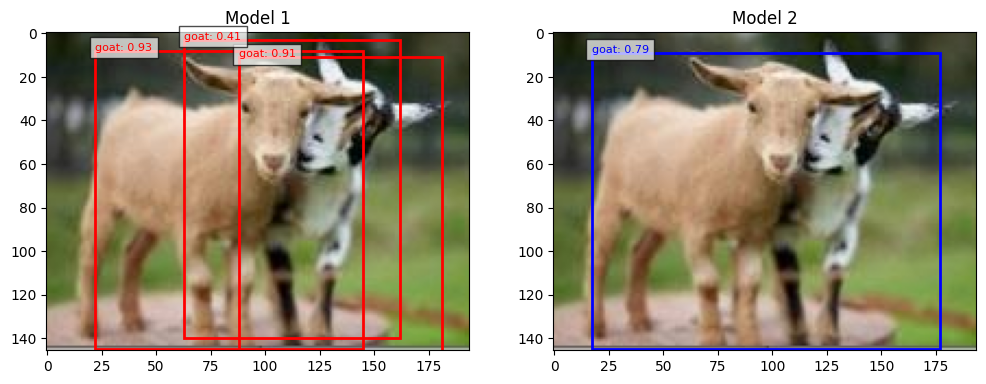

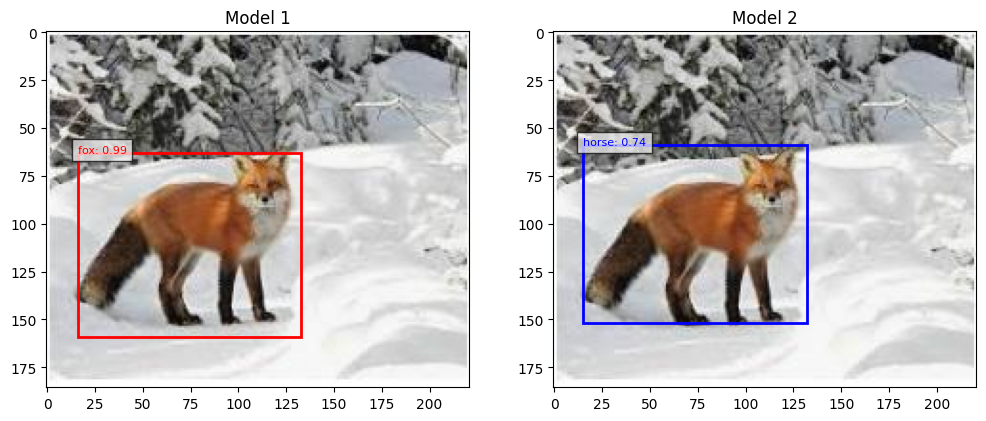

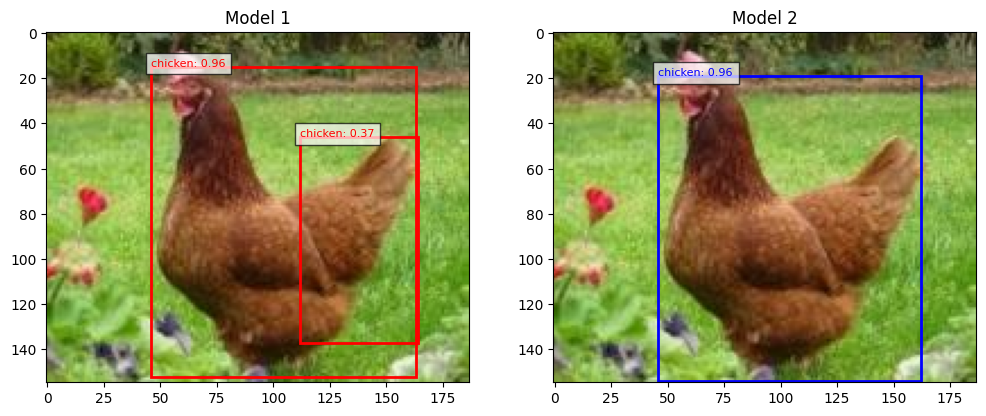

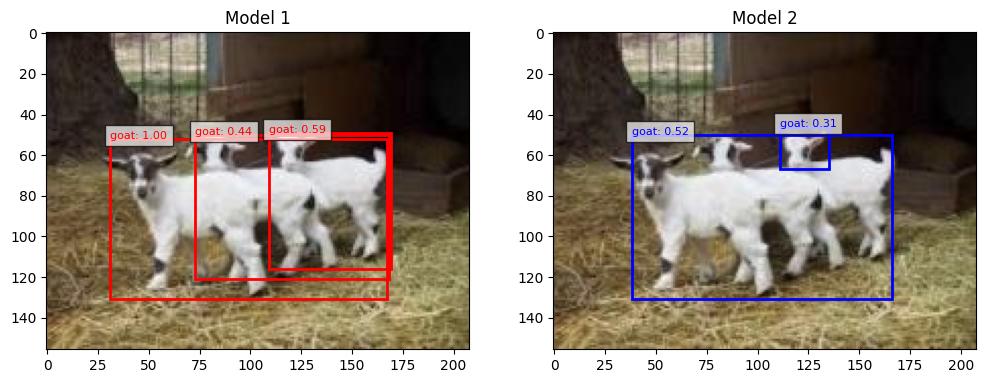

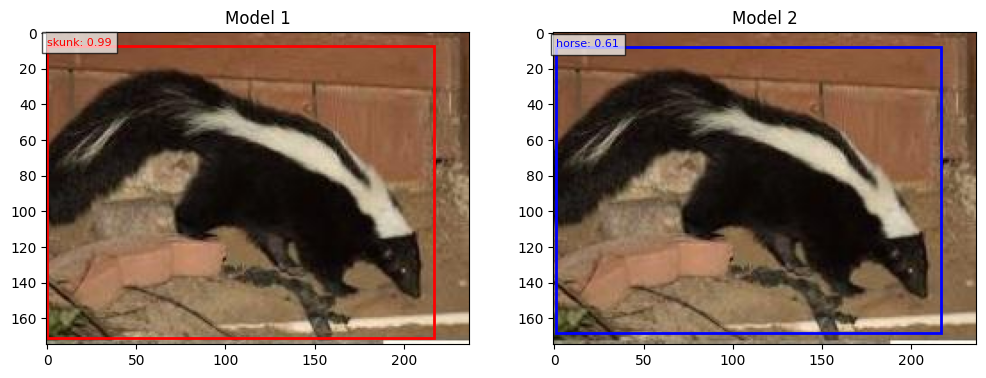

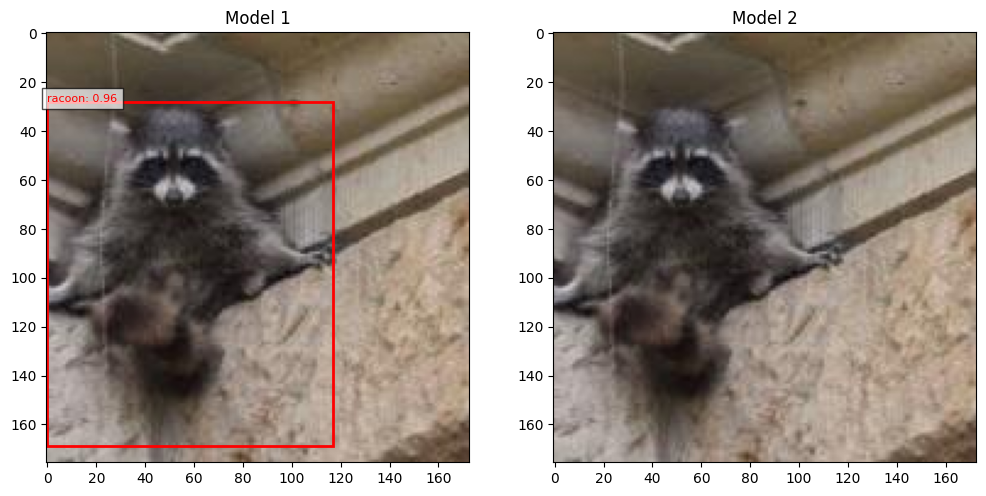

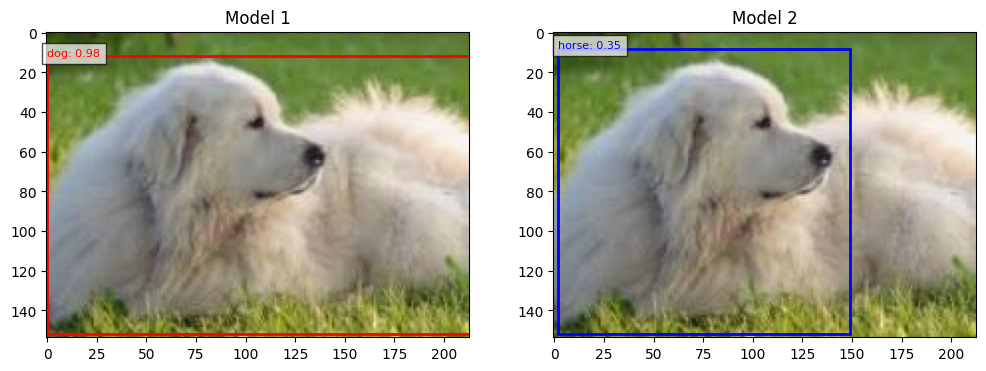

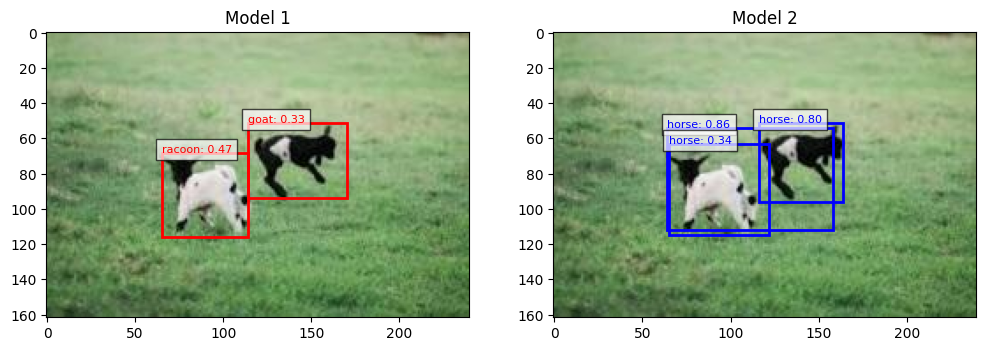

In [5]:
# Object detection and tracking code
model_folder_name_1 = 'ssd_mobilenet'
model_folder_name_2 = 'EfficientDet'

import os
import cv2
import numpy as np
import sys
import glob
import random
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def tflite_detect_images_dual_models(modelpath_1, modelpath_2, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

    images = glob.glob(imgpath + '/*.jpg') + glob.glob(imgpath + '/*.JPG') + glob.glob(imgpath + '/*.png') + glob.glob(imgpath + '/*.bmp')

    with open(lblpath, 'r') as f:
        labels = [line.strip() for line in f.readlines()]

    interpreter_1 = Interpreter(model_path=modelpath_1)
    interpreter_1.allocate_tensors()

    interpreter_2 = Interpreter(model_path=modelpath_2)
    interpreter_2.allocate_tensors()

    input_details_1 = interpreter_1.get_input_details()
    output_details_1 = interpreter_1.get_output_details()
    height_model_1, width_model_1 = input_details_1[0]['shape'][1], input_details_1[0]['shape'][2]

    input_details_2 = interpreter_2.get_input_details()
    output_details_2 = interpreter_2.get_output_details()
    height_model_2, width_model_2 = input_details_2[0]['shape'][1], input_details_2[0]['shape'][2]

    float_input_1 = (input_details_1[0]['dtype'] == np.float32)
    float_input_2 = (input_details_2[0]['dtype'] == np.float32)

    # images_to_test = imgpath # for single path

    images_to_test = random.sample(images, num_test_images)

    for image_path in images_to_test:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        imH, imW, _ = image.shape

        # Model 1
        input_frame_1 = cv2.resize(image_rgb, (width_model_1, height_model_1))
        input_data_1 = np.expand_dims(input_frame_1, axis=0)

        if float_input_1:
            input_data_1 = (np.float32(input_data_1) - 127.5) / 127.5

        interpreter_1.set_tensor(input_details_1[0]['index'], input_data_1)
        interpreter_1.invoke()

        # Result for Model 1
        boxes_1 = interpreter_1.get_tensor(output_details_1[1]['index'])[0]
        classes_1 = interpreter_1.get_tensor(output_details_1[3]['index'])[0]
        scores_1 = interpreter_1.get_tensor(output_details_1[0]['index'])[0]

        # Model 2
        input_frame_2 = cv2.resize(image_rgb, (width_model_2, height_model_2))
        input_data_2 = np.expand_dims(input_frame_2, axis=0)

        if float_input_2:
            input_data_2 = (np.float32(input_data_2) - 127.5) / 127.5

        interpreter_2.set_tensor(input_details_2[0]['index'], input_data_2)
        interpreter_2.invoke()

        # Result for Model 2
        boxes_2 = interpreter_2.get_tensor(output_details_2[1]['index'])[0]
        classes_2 = interpreter_2.get_tensor(output_details_2[3]['index'])[0]
        scores_2 = interpreter_2.get_tensor(output_details_2[0]['index'])[0]

        detections_1 = []
        detections_2 = []

        for i in range(len(scores_1)):
            if (scores_1[i] > min_conf) and (scores_1[i] <= 1.0):
                ymin, xmin, ymax, xmax = boxes_1[i]
                detections_1.append([labels[int(classes_1[i])], scores_1[i], int(xmin * width_model_1), int(ymin * height_model_1), int(xmax * width_model_1), int(ymax * height_model_1)])

        for i in range(len(scores_2)):
            if (scores_2[i] > min_conf) and (scores_2[i] <= 1.0):
                ymin, xmin, ymax, xmax = boxes_2[i]
                detections_2.append([labels[int(classes_2[i])], scores_2[i], int(xmin * width_model_2), int(ymin * height_model_2), int(xmax * width_model_2), int(ymax * height_model_2)])

        if txt_only == False:
            plt.figure(figsize=(12, 6))

            # Display results for Model 1
            plt.subplot(1, 2, 1)
            plt.imshow(image_rgb)
            plt.title("Model 1")
            for detection in detections_1:
                xmin, ymin, xmax, ymax = detection[2:]
                xmin = int(xmin * imW / width_model_1)
                xmax = int(xmax * imW / width_model_1)
                ymin = int(ymin * imH / height_model_1)
                ymax = int(ymax * imH / height_model_1)
                plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2))
                plt.text(xmin, ymin, f"{detection[0]}: {detection[1]:.2f}", color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

            # Display results for Model 2
            plt.subplot(1, 2, 2)
            plt.imshow(image_rgb)
            plt.title("Model 2")
            for detection in detections_2:
                xmin, ymin, xmax, ymax = detection[2:]
                xmin = int(xmin * imW / width_model_2)
                xmax = int(xmax * imW / width_model_2)
                ymin = int(ymin * imH / height_model_2)
                ymax = int(ymax * imH / height_model_2)
                plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='blue', linewidth=2))
                plt.text(xmin, ymin, f"{detection[0]}: {detection[1]:.2f}", color='blue', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

            plt.show()


        elif txt_only == True:
            image_fn = os.path.basename(image_path)
            base_fn, ext = os.path.splitext(image_fn)
            txt_result_fn_1 = base_fn + '_model1.txt'
            txt_result_fn_2 = base_fn + '_model2.txt'
            txt_savepath_1 = os.path.join(savepath, txt_result_fn_1)
            txt_savepath_2 = os.path.join(savepath, txt_result_fn_2)

            with open(txt_savepath_1, 'w') as f1:
                for detection in detections_1:
                    f1.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

            with open(txt_savepath_2, 'w') as f2:
                for detection in detections_2:
                    f2.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

    return

PATH_TO_IMAGES = '/content/animal_images/test_image'
PATH_TO_MODEL_1 = f'/content/{model_folder_name_1}/detect.tflite'
PATH_TO_MODEL_2 = f'/content/{model_folder_name_2}/detect.tflite'
PATH_TO_LABELS = '/content/animal_images/label_map.txt'
min_conf_threshold = 0.3
images_to_test = 10

tflite_detect_images_dual_models(PATH_TO_MODEL_1, PATH_TO_MODEL_2, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)


**7.2 Differences between the two model results**

**Model Comparison:**

Model A (ssd-mobilenet-v2-fpnlite-320):

    Batch Size: 16
    Epochs: 10,000
    Training Time: 0.24s per step
    Training Accuracy: 70% to 99%
    Prediction Accuracy: 3/4 correct
    Inference Speed: Same as Model B
    Object Detection: Performs well

Model B (efficientdet-d0):

    Batch Size: 4
    Epochs: 10,000
    Training Time: 0.29s per step
    Training Accuracy: 50% to 80%
    Prediction Accuracy: 2/4 correct
    Inference Speed: Same as Model A
    Object Detection: Average

**Conclusion:**

**Real-Time Performance:**

Model A (ssd-mobilenet) with a faster inference speed is preferable for real-time applications.

**Training Performance:**

Model A achieves higher accuracy during training.

**Prediction Accuracy:**

Model A has a higher prediction accuracy (3 out of 4 correct) compared to Model B (2 out of 4 correct).
